<a href="https://colab.research.google.com/github/nosadchiy/public/blob/main/SOP_Green_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Green Apple: Supply Planning case

Green Apple (GA) products are sold through retailers nationwide. Their operations consist of assembling purchases parts into a multipurpose gardening tool. Because of the limited equipment and space required for its operations, GA’s capacity is mainly determined by the size of its workforce.

Demand for GA’s products is highly seasonal peaking around April. In anticipation of the next season’s demand GA starts planning in the Fall for months of January through June. To meet the peak demand, GA can hire additional workers, subcontract some of the work or build up inventory during the slow months. It could also shift some demand in time by using promotions. Please determine the best use of these options by building an aggregate plan for: regular labor, overtime labor, number of units produced, inventory, subcontracting, and stockouts (backlogged demand).

```
+----------+-----------------+
| Month    | Demand Forecast |
+----------+-----------------+
| January  | 1,600           |
| February | 3,000           |
| March    | 3,200           |
| April    | 3,800           |
| May      | 2,200           |
| June     | 2,200           |
+----------+-----------------+

+-----------------------------+---------------+
| Item                        | Cost          |
+-----------------------------+---------------+
| Materials                   | $10/unit      |
| Inventory holding cost      | $2/unit/month |
| Marginal cost of a stockout | $5/unit/month |
| Hiring and training costs   | $300/worker   |
| Layoff cost                 | $500/worker   |
| Labor hours required        | 4/unit        |
| Regular time cost           | $4/hour       |
| Over time cost              | $6/hour       |
| Cost of subcontracting      | $30/unit      |
+-----------------------------+---------------+
```

* number of workers in the beginning of January: 80
* Initial inventory: 1000
* Minimum inventory at the end of June: 500 (business continuity) and no backlog
* Maximum use of overtime: 10 hours per worker
* Use of subcontracting: unlimited or limited to 500 per month
* Regular unit sales price: \$ 40
* Promotion price: \$ 39, results in an increase of consumption by 10% in the months of the promotion, and shifts 20% of demand from the future two months to the current month.

### Install and import packages

In [1]:
# Install and import packages
!pip install tabulate
!pip install gurobipy
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Raw Data

In [3]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

### Minimize cost using Gurobi integer optimizer

In [4]:
def plot_inventory():
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()

### Optimization problem

***Minimize Cost***

***subject to:***
  Workforce constraint

  Inventory balance constraint

  Production Capacity constraint

  Overtime constraint
  
  Demand and Stockout constraint

***Decision Variables***

Ht  = Number of employees hired at the beginning of month t, t = 1, ..., 6

Lt  = Number of employees laid off at the beginning of month t, t = 1, ..., 6

Wt  = Workforce size for month t, t = 1, ..., 6

Ot  = Number of overtime hours worked in month t, t = 1, ..., 6

It  = Inventory at the end of month t, t = 1, ..., 6

St  = Number of units stocked out at the end of month t, t = 1, ..., 6

Ct  = Number of units subcontracted for month t, t = 1, ..., 6

Pt  = Production in month t, t = 1, ..., 6

Dt  = Computed Demand in month t, t = 1, ..., 6

Q1


Minimum Total Cost: $ 422,660.00
Total Revenue: $ 640,000.00
Profit: $ 217,340.00


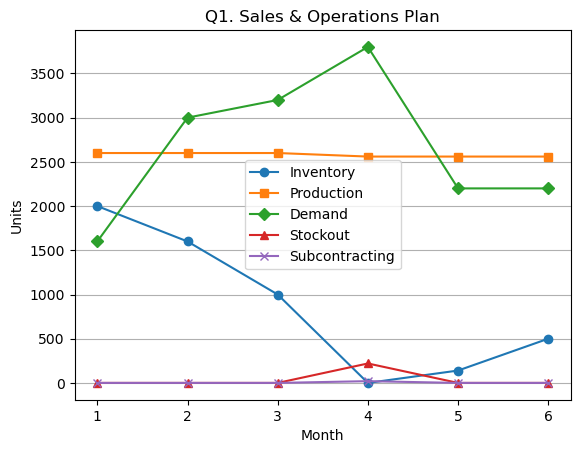

In [15]:
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

# Initial Forecasted Demand (Jan - June)
F_initial = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])  # Jan to June
n_months = len(F_initial) - 1  # 6 months (Jan - June)

# Constants
initial_inventory = 1000
initial_workforce = 80
base_price = 40

# Create Gurobi Model
model = Model("MinimizeCost")

# Decision Variables
H = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update Model
model.update()

# Objective Function: Minimize total cost
model.setObjective(
    quicksum(300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1)),
    GRB.MINIMIZE
)

# Constraints
for t in range(1, n_months+1):
    model.addConstr(W[0] == initial_workforce, name="Initial_Workforce")
    model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_Size_{t}")
    model.addConstr(D[t] == F_initial[t], name=f"Demand_Constraint_{t}")
    model.addConstr(I[0] == initial_inventory, name="Initial_Inventory")
    model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_Balance_{t}")
    model.addConstr(I[n_months] >= 500, name="Final_Inventory")
    model.addConstr(S[n_months] == 0, name="Final_Stockout")
    model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Production_Capacity_{t}")
    model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_Limit_{t}")

# Suppress Output
model.Params.OutputFlag = 0

# Solve Model
model.optimize()

# Extract Results
total_cost = model.objVal
total_revenue = sum(D[t].x * base_price for t in range(1, n_months+1))
profit = total_revenue - total_cost

# Store results in a DataFrame for plotting
df_results = pd.DataFrame({
    "Month": list(range(1, n_months+1)),
    "Inventory": [I[t].x for t in range(1, n_months+1)],
    "Production": [P[t].x for t in range(1, n_months+1)],
    "Demand": [D[t].x for t in range(1, n_months+1)],
    "Stockout": [S[t].x for t in range(1, n_months+1)],
    "Subcontract": [C[t].x for t in range(1, n_months+1)]
})

# Print Final Summary
print(f"\nMinimum Total Cost: $ {total_cost:,.2f}")
print(f"Total Revenue: $ {total_revenue:,.2f}")
print(f"Profit: $ {profit:,.2f}")

# Plot results using the original structure
def plot_results():
    months = df_results["Month"]
    plt.plot(months, df_results["Inventory"], marker='o', label="Inventory")
    plt.plot(months, df_results["Production"], marker='s', label="Production")
    plt.plot(months, df_results["Demand"], marker='D', label="Demand")
    plt.plot(months, df_results["Stockout"], marker='^', label="Stockout")
    plt.plot(months, df_results["Subcontract"], marker='x', label="Subcontracting")

    plt.xlabel("Month")
    plt.ylabel("Units")
    plt.title("Q1. Sales & Operations Plan")
    plt.legend(loc='best')
    plt.grid(axis='y')
    plt.show()

# Generate the plot
plot_results()


q2

At the end of January, new information was received:

Realized January Demand: 1,400 units (instead of 1,600).

New Forecast for April: 3,900 units (instead of previous value).

New Demand for July: 1,200 units (previously not included).

Impact of Changes:

Extra inventory of 200 units (because demand in January was lower).

Future adjustments in production & stock levels are needed.

April's increased demand (3,900) requires planning adjustments.

July's new demand (1,200) extends the planning horizon.


q3


Impact of January's Demand Change:
Realized January Inventory: 3,200
Cost Difference for Feb - June: $-205,500.00


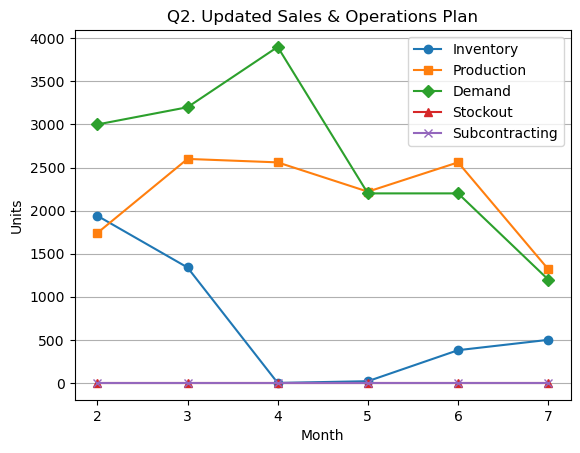

In [16]:
# Updated Forecasted Demand (After Jan realization & April/July changes)
F_updated = np.array([0, 1400, 3000, 3200, 3900, 2200, 2200, 1200])  # Jan to July
n_months_updated = len(F_updated) - 1  # 7 months (Jan - July)

# Compute the new starting inventory after realizing January demand
realized_inventory_jan = I[1].x + P[1].x - 1400  # Adjusted demand

# Create new Gurobi model starting from February with updated forecasts
model_updated = Model("MinimizeCostUpdated")

# Decision Variables
H_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(1, n_months_updated+1)}
L_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(1, n_months_updated+1)}
W_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(1, n_months_updated+1)}
O_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(1, n_months_updated+1)}
I_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(1, n_months_updated+1)}
S_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(1, n_months_updated+1)}
C_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(1, n_months_updated+1)}
P_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(1, n_months_updated+1)}
D_new = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(1, n_months_updated+1)}

# Update Model
model_updated.update()

# Objective Function: Minimize total cost
model_updated.setObjective(
    quicksum(300*H_new[t] + 500*L_new[t] + 640*W_new[t] + 6*O_new[t] + 2*I_new[t] + 5*S_new[t] + 30*C_new[t] + 10*P_new[t] for t in range(2, n_months_updated+1)),
    GRB.MINIMIZE
)

# Constraints
for t in range(2, n_months_updated+1):  # Start from Feb (t=2)
    model_updated.addConstr(W_new[t-1] == W[t-1].x, name=f"Initial_Workforce_{t}")
    model_updated.addConstr(W_new[t] - W_new[t-1] - H_new[t] + L_new[t] == 0, name=f"Workforce_Size_{t}")
    model_updated.addConstr(D_new[t] == F_updated[t], name=f"Demand_Constraint_{t}")
    model_updated.addConstr(I_new[1] == realized_inventory_jan, name="Updated_Inventory_Jan")
    model_updated.addConstr(I_new[t-1] + P_new[t] + C_new[t] - D_new[t] - S_new[t-1] - I_new[t] + S_new[t] == 0, name=f"Inventory_Balance_{t}")
    model_updated.addConstr(I_new[n_months_updated] >= 500, name="Final_Inventory")
    model_updated.addConstr(S_new[n_months_updated] == 0, name="Final_Stockout")
    model_updated.addConstr(40*W_new[t] + O_new[t]/4 - P_new[t] >= 0, name=f"Production_Capacity_{t}")
    model_updated.addConstr(10*W_new[t] - O_new[t] >= 0, name=f"Overtime_Limit_{t}")

# Suppress Output
model_updated.Params.OutputFlag = 0

# Solve Model
model_updated.optimize()

# Extract Updated Costs
costs_updated = {t: model_updated.getObjective().getValue() for t in range(2, n_months_updated+1)}

# Compute cost difference for Feb - June
cost_difference = sum(costs_updated[t] - costs[t] for t in range(2, 7))

# Print Results
print("\nImpact of January's Demand Change:")
print(f"Realized January Inventory: {realized_inventory_jan:,.0f}")
print(f"Cost Difference for Feb - June: ${cost_difference:,.2f}")

# Updated Plot
df_results_updated = pd.DataFrame({
    "Month": list(range(2, n_months_updated+1)),
    "Inventory": [I_new[t].x for t in range(2, n_months_updated+1)],
    "Production": [P_new[t].x for t in range(2, n_months_updated+1)],
    "Demand": [D_new[t].x for t in range(2, n_months_updated+1)],
    "Stockout": [S_new[t].x for t in range(2, n_months_updated+1)],
    "Subcontract": [C_new[t].x for t in range(2, n_months_updated+1)]
})

# Plot results
def plot_updated_results():
    months = df_results_updated["Month"]
    plt.plot(months, df_results_updated["Inventory"], marker='o', label="Inventory")
    plt.plot(months, df_results_updated["Production"], marker='s', label="Production")
    plt.plot(months, df_results_updated["Demand"], marker='D', label="Demand")
    plt.plot(months, df_results_updated["Stockout"], marker='^', label="Stockout")
    plt.plot(months, df_results_updated["Subcontract"], marker='x', label="Subcontracting")

    plt.xlabel("Month")
    plt.ylabel("Units")
    plt.title("Q2. Updated Sales & Operations Plan")
    plt.legend(loc='best')
    plt.grid(axis='y')
    plt.show()

# Generate the plot
plot_updated_results()


q3

Impact of January's Demand Change

The decrease in **January's actual demand** from **1,600 to 1,400 units** resulted in a **cost increase of $2,400**, raising the total cost from **$79,100 to $81,500**.  

Since **production proceeded as originally planned**, the company likely accumulated **excess inventory**, leading to **higher storage costs** or adjustments in **February's production plan**. While the immediate effect of lower demand was an **increase in costs**, the impact on **future months remains uncertain**. The **excess inventory may reduce production needs in February** or **increase holding costs** if not managed properly.  

This shift shows the **importance of adaptive production planning** to respond to **demand fluctuations** and avoid **inefficiencies**.


Summary of Cost Impact

| **Metric**          | **Planned**    | **Realized**    | **Difference**       |
|---------------------|---------------|----------------|----------------------|
| **January Demand**  | 1,600 units    | 1,400 units    | **-200 units**       |
| **January Cost**    | $79,100.00     | $81,500.00     | **+$2,400.00**       |
| **Excess Inventory**| 0 units        | 200 units      | **+200 units**       |
| **Holding Cost Increase** | $0 | $400 | **+$400.00** |



In [17]:
# Compute the original planned cost for January
planned_cost_jan = (
    300 * H[1].x + 
    500 * L[1].x + 
    640 * W[1].x + 
    6 * O[1].x + 
    2 * I[1].x + 
    5 * S[1].x + 
    30 * C[1].x + 
    10 * P[1].x
)

# Compute the realized cost for January (adjusted demand)
realized_inventory_jan = I[1].x + P[1].x - 1400  # Adjusted demand
realized_cost_jan = (
    300 * H[1].x + 
    500 * L[1].x + 
    640 * W[1].x + 
    6 * O[1].x + 
    2 * realized_inventory_jan +  # Holding cost affected
    5 * S[1].x + 
    30 * C[1].x + 
    10 * P[1].x
)

# Compute the cost difference
cost_difference_jan = realized_cost_jan - planned_cost_jan

# Print results
print("\nImpact of January's Realized Demand on January's Costs:")
print(f"Planned January Cost: ${planned_cost_jan:,.2f}")
print(f"Realized January Cost: ${realized_cost_jan:,.2f}")
print(f"Cost Difference: ${cost_difference_jan:,.2f}")



Impact of January's Realized Demand on January's Costs:
Planned January Cost: $79,100.00
Realized January Cost: $81,500.00
Cost Difference: $2,400.00


q4

+-------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+------------+-----------------+
| Month | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price | Total Cost | Cost Difference |
+-------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+------------+-----------------+
|  1.0  | -0.0  |   -0.0   |   58.0    |   -0.0   |  3120.0   |   0.0    |    -0.0     |    -0.0    | 1400.0 | 40.0  |  43360.0   |     43360.0     |
|  2.0  |  0.0  |   -0.0   |   58.0    |   -0.0   |  2440.0   |   -0.0   |    -0.0     |   2320.0   | 3000.0 | 40.0  |  65200.0   |     -5600.0     |
|  3.0  |  0.0  |   -0.0   |   58.0    |   -0.0   |  1560.0   |   -0.0   |     0.0     |   2320.0   | 3200.0 | 40.0  |  63440.0   |     -6160.0     |
|  4.0  |  0.0  |   -0.0   |   58.0    |   -0.0   |   -0.0    |   20.0   |     0.0     |   2320.0   

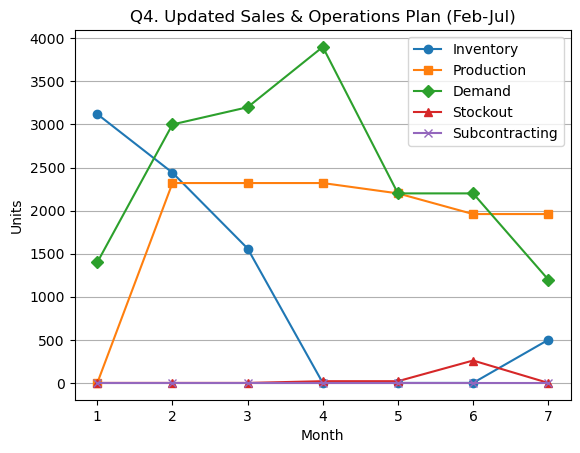

In [28]:
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from tabulate import tabulate  # For better table display

# Updated Demand Forecast (Feb-Jul)
F = np.array([0, 1400, 3000, 3200, 3900, 2200, 2200, 1200])

# Number of months in the updated period
n_months = len(F) - 1

# Cost Parameters
cost_hiring = 300
cost_layoff = 500
cost_worker = 640  # 40 hours * $4 per hour
cost_overtime_hour = 6
cost_inventory_holding = 2
cost_stockout = 5
cost_subcontracting = 30
cost_material = 10
hours_per_unit = 4
max_overtime_hours = 10
base_price = 40  # Selling price per unit

# Original Costs from Q1 for Feb–June
original_costs_by_month = {
    2: 70800,  # February
    3: 69600,  # March
    4: 68760,  # April
    5: 66840,  # May
    6: 67560   # June
}

# Updated Initial Conditions (From Q2 Results - End of Jan)
initial_workers = 58  # Workforce after January (Q2)
initial_inventory = 3120  # End-of-Jan inventory from Q2
initial_stockout = 0  # Assume no stockouts at end of January
min_inventory_end = 500  # Minimum required at the end

# Create Gurobi Model
model = Model("Updated_S&OP")

# Decision Variables
H = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(1, n_months+1)}
L = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(1, n_months+1)}
W = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(1, n_months+1)}
O = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(1, n_months+1)}
I = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(1, n_months+1)}
S = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(1, n_months+1)}
C = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(1, n_months+1)}
P = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(1, n_months+1)}

# **Define Initial Conditions as Constraints**
model.addConstr(W[1] == initial_workers, name="Initial_Workforce")
model.addConstr(I[1] == initial_inventory, name="Initial_Inventory")

# Objective Function: Minimize Total Cost
model.setObjective(
    quicksum(
        cost_hiring * H[t] + cost_layoff * L[t] +
        cost_worker * W[t] + cost_overtime_hour * O[t] +
        cost_inventory_holding * I[t] + cost_stockout * S[t] +
        cost_subcontracting * C[t] + cost_material * P[t]
        for t in range(1, n_months+1)
    ), GRB.MINIMIZE
)

# Constraints
for t in range(1, n_months+1):
    # Workforce size constraint (Avoid referencing W[0])
    if t > 1:
        model.addConstr(W[t] == W[t-1] + H[t] - L[t], name=f"Workforce_size_{t}")

    # Inventory balance constraint (Avoid referencing I[0])
    if t > 1:
        model.addConstr(
            I[t] == I[t-1] + P[t] + C[t] - F[t] - S[t-1] + S[t],
            name=f"Inventory_balance_{t}"
        )

    # Production capacity constraint
    model.addConstr(P[t] <= 40 * W[t] + O[t] / 4, name=f"Production_capacity_{t}")

    # Overtime constraint
    model.addConstr(O[t] <= max_overtime_hours * W[t], name=f"Overtime_constraint_{t}")

# Final conditions
model.addConstr(I[n_months] >= min_inventory_end, name="Final_Inventory")
model.addConstr(S[n_months] == 0, name="Final_Stockout")

# Suppress output
model.Params.OutputFlag = 0

# Optimize Model
model.optimize()

# Extract Results
results = []
total_revenue = 0
total_cost_difference = 0  # Track total cost difference from original plan

for t in range(1, n_months+1):
    price = base_price  # Assume fixed price per unit
    revenue = F[t] * price
    total_revenue += revenue

    total_cost = (
        cost_hiring * H[t].x + cost_layoff * L[t].x +
        cost_worker * W[t].x + cost_overtime_hour * O[t].x +
        cost_inventory_holding * I[t].x + cost_stockout * S[t].x +
        cost_subcontracting * C[t].x + cost_material * P[t].x
    )

    # **Calculate Cost Difference (Feb–June Only)**
    cost_difference = total_cost - original_costs_by_month.get(t, 0)
    if 2 <= t <= 6:  # Only consider Feb–June for total difference
        total_cost_difference += cost_difference

    results.append([
        t, H[t].x, L[t].x, W[t].x, O[t].x, I[t].x, S[t].x, C[t].x, P[t].x, F[t], price, total_cost, cost_difference
    ])

# Convert to DataFrame
columns = ["Month", "Hired", "Laid Off", "Workforce", "Overtime", "Inventory", "Stockout",
           "Subcontract", "Production", "Demand", "Price", "Total Cost", "Cost Difference"]
df_updated = pd.DataFrame(results, columns=columns)

# Print Tabular Format
print(tabulate(df_updated, headers="keys", tablefmt="pretty", showindex=False))

# Print Results
print(f"\nUpdated Minimum Total Cost: $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {total_revenue:,.2f}")
print(f"Profit: $ {(total_revenue - model.objVal):,.2f}")

# **Final Cost Difference Calculation**
print(f"\nTotal Cost Difference between Updated Plan and Original Plan (Feb–June): $ {total_cost_difference:,.2f}")

# Plot Results
plt.plot(df_updated["Month"], df_updated["Inventory"], marker='o', label="Inventory")
plt.plot(df_updated["Month"], df_updated["Production"], marker='s', label="Production")
plt.plot(df_updated["Month"], df_updated["Demand"], marker='D', label="Demand")
plt.plot(df_updated["Month"], df_updated["Stockout"], marker='^', label="Stockout")
plt.plot(df_updated["Month"], df_updated["Subcontract"], marker='x', label="Subcontracting")

plt.xlabel("Month")
plt.ylabel("Units")
plt.title("Q4. Updated Sales & Operations Plan (Feb-Jul)")
plt.legend(loc='best')
plt.grid(axis='y')
plt.show()
